In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


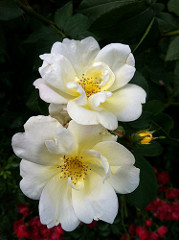

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

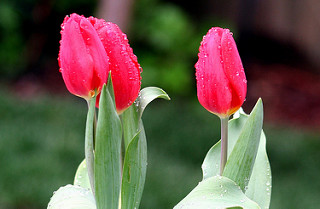

In [9]:
tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[0]))

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


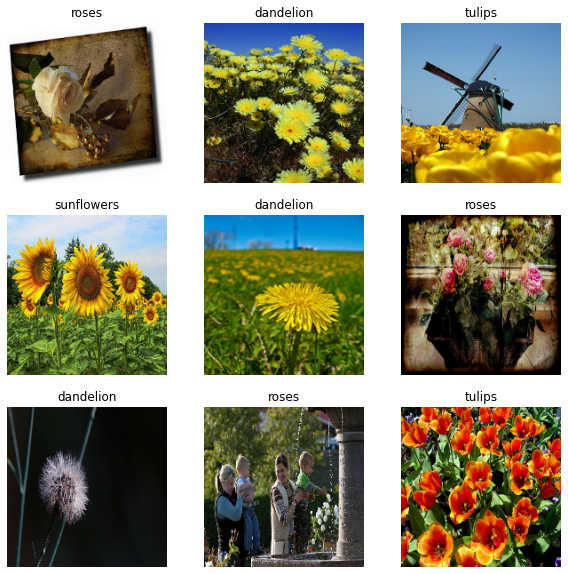

In [15]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [24]:
epoches = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoches
)

Epoch 1/10
92/92 [==============================] - 84s 243ms/step - loss: 1.4583 - accuracy: 0.3965 - val_loss: 1.0790 - val_accuracy: 0.5940
Epoch 2/10
92/92 [==============================] - 8s 83ms/step - loss: 0.9634 - accuracy: 0.6208 - val_loss: 0.9074 - val_accuracy: 0.6540
Epoch 3/10
92/92 [==============================] - 8s 82ms/step - loss: 0.7519 - accuracy: 0.7097 - val_loss: 1.0797 - val_accuracy: 0.6349
Epoch 4/10
92/92 [==============================] - 8s 82ms/step - loss: 0.5611 - accuracy: 0.8052 - val_loss: 0.9558 - val_accuracy: 0.6621
Epoch 5/10
92/92 [==============================] - 8s 83ms/step - loss: 0.3034 - accuracy: 0.9029 - val_loss: 1.0840 - val_accuracy: 0.6621
Epoch 6/10
92/92 [==============================] - 8s 82ms/step - loss: 0.1634 - accuracy: 0.9526 - val_loss: 1.2224 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 7s 81ms/step - loss: 0.1016 - accuracy: 0.9732 - val_loss: 1.3868 - val_accuracy: 0.6649
Epoch 8/10


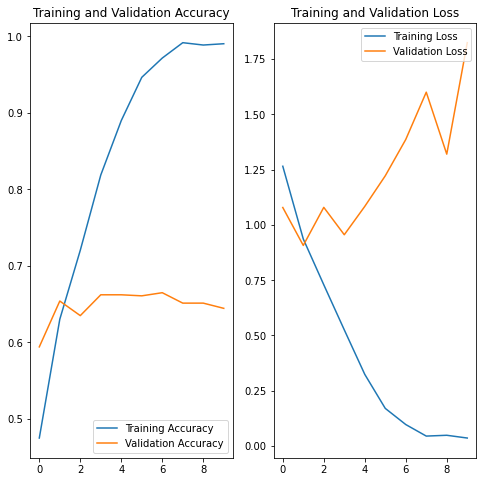

In [26]:
acc = history.history["accuracy"]
val_acc =history.history["val_accuracy"]

loss = history.history["loss"]
val_loss =history.history["val_loss"]

epochs_range = range(epoches)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


In [27]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

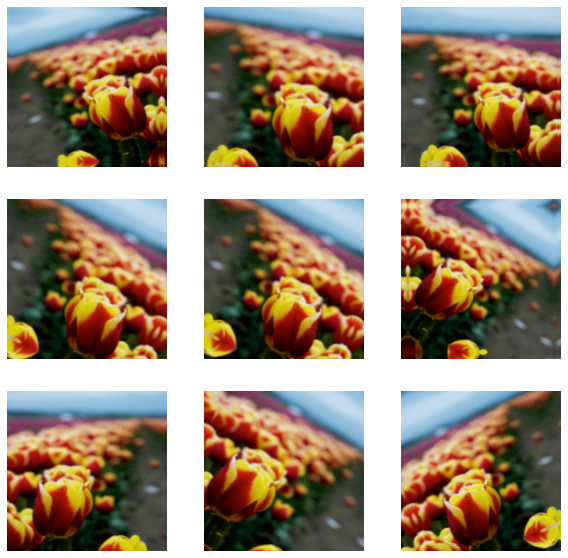

In [28]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [29]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [32]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 12s 107ms/step - loss: 1.4985 - accuracy: 0.3218 - val_loss: 1.1074 - val_accuracy: 0.5327
Epoch 2/15
92/92 [==============================] - 9s 98ms/step - loss: 1.1059 - accuracy: 0.5373 - val_loss: 1.0292 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 9s 97ms/step - loss: 0.9757 - accuracy: 0.5982 - val_loss: 0.9295 - val_accuracy: 0.6199
Epoch 4/15
92/92 [==============================] - 9s 97ms/step - loss: 0.9170 - accuracy: 0.6380 - val_loss: 0.9119 - val_accuracy: 0.6253
Epoch 5/15
92/92 [==============================] - 9s 98ms/step - loss: 0.8201 - accuracy: 0.6736 - val_loss: 0.8670 - val_accuracy: 0.6499
Epoch 6/15
92/92 [==============================] - 9s 98ms/step - loss: 0.7585 - accuracy: 0.7160 - val_loss: 0.9044 - val_accuracy: 0.6390
Epoch 7/15
92/92 [==============================] - 9s 99ms/step - loss: 0.7503 - accuracy: 0.7114 - val_loss: 0.7775 - val_accuracy: 0.7030
Epoch 8/15


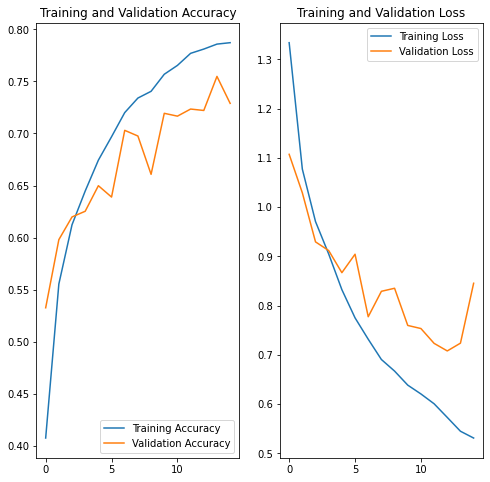

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 1us/step
This image most likely belongs to sunflowers with a 99.61 percent confidence.
